### Let's first configure the Spark cluster
<b>Make sure that:<br> </b>
1. You are adding the right Sparkling Water version
> For Spark 2.0 -> use the latest Sparkling Water 2.0 Maven coordinates [here](https://mvnrepository.com/artifact/ai.h2o/sparkling-water-core_2.11)<br>
> For Spark 1.6 -> use the lastest Sparkling Water 1.6 Maven coordinates [here](https://mvnrepository.com/artifact/ai.h2o/sparkling-water-core_2.10)
2. Set the driver and executor memory to a max of 75% (see [here](http://spark.apache.org/docs/latest/hardware-provisioning.html)) of the RAM of the worker VM types selected on cluster creation
>The default worker VM type is D13_v2 (56G RAM, 8 cores), so 75% of RAM = 42G<br>
>For information on all available VM sizes click [here](https://azure.microsoft.com/en-us/documentation/articles/virtual-machines-windows-sizes/#dv2-series) 
3. Set numExecutors to the amount of workers created in the clusters.
>The default number of worker nodes is 3<br>

In [1]:
%%configure -f
{
    "conf":{
        "spark.jars.packages":"ai.h2o:sparkling-water-core_2.11:2.0.2,com.databricks:spark-csv_2.10:1.5.0",
        "spark.locality.wait":"3000",
        "spark.scheduler.minRegisteredResourcesRatio":"1",
        "spark.task.maxFailures":"1",
        "spark.yarn.am.extraJavaOption":"-XX:MaxPermSize=384m",
        "spark.yarn.max.executor.failures":"1",
        "maximizeResourceAllocation": "true"
    },
    "driverMemory":"42G",
    "executorMemory":"42G",
    "numExecutors":3
}

Here we add the pySpark egg file from the downloaded H2O Sparkling water distribution.
<br><b> Make sure that file name of the egg file below matches the downloaded distribution of Sparkling Water</b>

In [2]:
import os
os.environ["PYTHON_EGG_CACHE"] = "~/"

#Spark 2.0
sc.addPyFile('wasb:///H2O-Sparkling-Water-eggsfiles/pySparkling-2.0.egg')

#Spark 1.6
#sc.addPyFile('wasb:///H2O-Sparkling-Water-eggsfiles/pySparkling-1.6.egg')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1481782795248_0007,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


# Sentiment Analysis with PySparkling
The Amazon Fine Food Reviews dataset consists of 568,454 food reviews Amazon users left up to October 2012.

> This data was originally published on SNAP as part of the paper: J. McAuley and J. Leskovec. _From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews_. WWW, 2013.

https://www.kaggle.com/snap/amazon-fine-food-reviews

## Prepare environment

In [3]:
import pyspark
import pysparkling, h2o

h2o_context = pysparkling.H2OContext.getOrCreate(sc)

Checking whether there is an H2O instance running at http://192.168.0.6:54321. connected.
--------------------------  -------------------------------
H2O cluster uptime:         11 secs
H2O cluster version:        3.10.0.10
H2O cluster version age:    1 month and 7 days
H2O cluster name:           sparkling-water-yarn_1021435016
H2O cluster total nodes:    2
H2O cluster free memory:    74.7 Gb
H2O cluster total cores:    16
H2O cluster allowed cores:  16
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://192.168.0.6:54321
H2O connection proxy:
Python version:             2.7.12 final
--------------------------  -------------------------------

## Load data into H2OFrame

In [4]:
# This is just helper function returning the path to public data file Reviews.csv ~ 300MB size
def _locate(example_name): 
    return "https://h2ostore.blob.core.windows.net/examples/" + example_name 

AMAZON_DATASET = 'Reviews.csv'

# Add files to Spark Cluster

sc.addFile(_locate(AMAZON_DATASET))

In [5]:
# And import them into H2O
from pyspark import SparkFiles

# Since we have already loaded files into spark, we have to use h2o.upload_file instead of 
# h2o.import_file since h2o.import_file expects cluster-relative path (ie. the file on this
# path can be accessed from all the machines on the cluster) but SparkFiles.get(..) already
# give us relative path to the file on a current node which h2o.upload_file can handle ( it
# uploads file located on current node and distributes it to the H2O cluster)

reviews_hf = h2o.upload_file(SparkFiles.get(AMAZON_DATASET))


Parse progress: [#########################################################] 100%

In [6]:
reviews_hf.show()

  Id  ProductId    UserId          ProfileName                        HelpfulnessNumerator    HelpfulnessDenominator    Score         Time  Summary                                        Text
----  -----------  --------------  -------------------------------  ----------------------  ------------------------  -------  -----------  ---------------------------------------------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   1  B001E4KFG0   A3SGXH7AUHU8GW  delmartian                                            1                     

## Data munge data with H2O API

### Remove columns

In [7]:
selected_columns = [ "Score", "Time", "Summary", "HelpfulnessNumerator", "HelpfulnessDenominator" ]
reviews_hf = reviews_hf[selected_columns]

In [8]:
reviews_hf.show()

  Score         Time  Summary                                          HelpfulnessNumerator    HelpfulnessDenominator
-------  -----------  ---------------------------------------------  ----------------------  ------------------------
      5  1.30386e+09  Good Quality Dog Food                                               1                         1
      1  1.34698e+09  Not as Advertised                                                   0                         0
      4  1.21902e+09  ""Delight"" says it a                                               1                         1
      2  1.30792e+09  Cough Medicine                                                      3                         3
      5  1.35078e+09  Great taffy                                                         0                         0
      4  1.34205e+09  Nice Taffy                                                          0                         0
      5  1.34015e+09  Great!  Just as good as the expens

### Refine `Time` Column into Year/Month/Day/DayOfWeek/Hour columns
In this case the `Time` column contains number of seconds from epoch. We translate it into several new columns to help algorithms to pick right pattern.

In [9]:
# Set time zone to UTC for date manipulation
h2o.set_timezone("Etc/UTC")

In [10]:
def refine_time_column(data_hf, column_name):
    data_hf[column_name] = data_hf[column_name] * 1000 # Transformation to microsecond since required by H2O API
    data_hf["Day"] = data_hf[column_name].day()
    data_hf["Month"] = data_hf[column_name].month()
    data_hf["Year"] = data_hf[column_name].year()
    data_hf["DayOfWeek"] = data_hf[column_name].dayOfWeek()
    data_hf["Hour"] = data_hf[column_name].hour()
    
refine_time_column(reviews_hf, "Time")
reviews_hf.show()

  Score         Time  Summary                                          HelpfulnessNumerator    HelpfulnessDenominator    Day    Month    Year  DayOfWeek      Hour
-------  -----------  ---------------------------------------------  ----------------------  ------------------------  -----  -------  ------  -----------  ------
      5  1.30386e+12  Good Quality Dog Food                                               1                         1     27        4    2011  Wed               0
      1  1.34698e+12  Not as Advertised                                                   0                         0      7        9    2012  Fri               0
      4  1.21902e+12  ""Delight"" says it a                                               1                         1     18        8    2008  Mon               0
      2  1.30792e+12  Cough Medicine                                                      3                         3     13        6    2011  Mon               0
      5  1.35078e+12  

## Data Munge with Spark API
We can combine H2O data munging capabilities with Spark API

### Publish H2O Frame as Spark DataFrame

The created H2OContext exposes the method `as_spark_frame` which publishes an H2OFrame as Spark DataFrame.

In [11]:
reviews_df = h2o_context.as_spark_frame(reviews_hf)
reviews_df.show()

+-----+-------------+--------------------+--------------------+----------------------+---+-----+----+---------+----+
|Score|         Time|             Summary|HelpfulnessNumerator|HelpfulnessDenominator|Day|Month|Year|DayOfWeek|Hour|
+-----+-------------+--------------------+--------------------+----------------------+---+-----+----+---------+----+
|    5|1303862400000|Good Quality Dog ...|                   1|                     1| 27|    4|2011|      Wed|   0|
|    1|1346976000000|   Not as Advertised|                   0|                     0|  7|    9|2012|      Fri|   0|
|    4|1219017600000|""Delight"" says ...|                   1|                     1| 18|    8|2008|      Mon|   0|
|    2|1307923200000|      Cough Medicine|                   3|                     3| 13|    6|2011|      Mon|   0|
|    5|1350777600000|         Great taffy|                   0|                     0| 21|   10|2012|      Sun|   0|
|    4|1342051200000|          Nice Taffy|                   0| 

In [12]:
# HERE is where we save the dataframe to a Hive Table
#reviews_df.saveAsTable("reviewstable") #Spark 2.0

sqlContext.registerDataFrameAsTable(reviews_df, "reviewstabletemp")
sqlContext.sql("create table reviewstable as select * from reviewstabletemp");


DataFrame[]

In [13]:
%%sql 
show tables

### Spark DataFrame API

From this point we can run any Spark data munging operations including SQL.
We can still publish the result as H2OFrame.

In [14]:
avgScorePerYear = reviews_df.groupBy("Year").agg({"Score" : "avg", "*": "count"}).orderBy("Year")
avgScorePerYear.show()

+----+------------------+--------+
|Year|        avg(Score)|count(1)|
+----+------------------+--------+
|1999|               5.0|       6|
|2000|           4.53125|      32|
|2001|3.5384615384615383|      13|
|2002| 4.712328767123288|      73|
|2003| 4.325757575757576|     132|
|2004| 4.392156862745098|     561|
|2005|4.4456928838951315|    1335|
|2006| 4.313446259931045|    6671|
|2007| 4.391345291479821|   22300|
|2008| 4.345344378421099|   34163|
|2009| 4.300365108628855|   55326|
|2010| 4.198837967491034|   85884|
|2011| 4.143803697511926|  163299|
|2012| 4.117885421752852|  198659|
+----+------------------+--------+

In [15]:
# Another df save to HIVE
sqlContext.registerDataFrameAsTable(avgScorePerYear, "avgscoretabletemp")
sqlContext.sql("create table avgscoretable as select * from avgscoretabletemp");

DataFrame[]

Now we can query the hive table and output the results on a pandas dataframe (using the -o option)

In [16]:
%%sql -q -n 500 -o query1
select * from avgscoretabletemp

### visualize the results directly in Python Notebook...

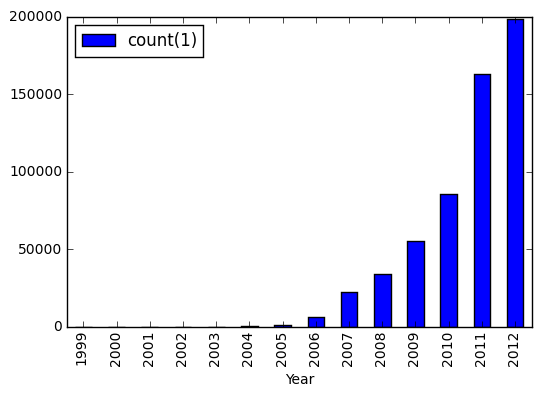

In [17]:
%%local
%matplotlib inline

query1.plot.bar(x="Year", y = "count(1)")

### Prepare data for modeling
The idea is to model sentiment based on `Score` of review, `Summary` and time when the review was performed. In this case we skip all neutral reviews, but focus on positive/negative scores.

Steps:

  1. Select columns Score, Month, Day, DayOfWeek, Summary
  2. Define UDF to transform score (0..5) to binary positive/negative
  3. Use TF-IDF to vectorize summary column

#### Transform the `Score` column into binary feature

The score contains value (0, 5), however we are just interested in binary value - positive/negative review. We ignore neutral reviews.

In [18]:
from pyspark.sql.types import *
from pyspark.sql.functions import UserDefinedFunction

def to_binary_score(col):
    if col < 3:
        return "negative"
    else:
        return "positive"
udf_to_binary_score = UserDefinedFunction(to_binary_score, StringType())

In [19]:
reviews_df = reviews_df.withColumn("Score", udf_to_binary_score("Score"))
reviews_df.show()

+--------+-------------+--------------------+--------------------+----------------------+---+-----+----+---------+----+
|   Score|         Time|             Summary|HelpfulnessNumerator|HelpfulnessDenominator|Day|Month|Year|DayOfWeek|Hour|
+--------+-------------+--------------------+--------------------+----------------------+---+-----+----+---------+----+
|positive|1303862400000|Good Quality Dog ...|                   1|                     1| 27|    4|2011|      Wed|   0|
|negative|1346976000000|   Not as Advertised|                   0|                     0|  7|    9|2012|      Fri|   0|
|positive|1219017600000|""Delight"" says ...|                   1|                     1| 18|    8|2008|      Mon|   0|
|negative|1307923200000|      Cough Medicine|                   3|                     3| 13|    6|2011|      Mon|   0|
|positive|1350777600000|         Great taffy|                   0|                     0| 21|   10|2012|      Sun|   0|
|positive|1342051200000|          Nice T

### Transforming textual data into numeric representation

#### Tokenization

In [20]:
from pyspark.ml.feature import *

tokenizer = Tokenizer(inputCol="Summary", outputCol="tokens")

#### Transform tokens into numeric representation

We use Spark `HashingTF` to represent tokens as numeric features.

In [21]:
hashingTF = HashingTF()
hashingTF.setInputCol("tokens").setOutputCol("tf-features").setNumFeatures(1024)

HashingTF_41169e4552b95a99859e

#### Build IDF (Inverse Document Frequency) model
The model scales a token frequency based on its occurence in a document and full set of documents.

In [22]:
idf = IDF()
idf.setInputCol("tf-features")
idf.setOutputCol("idf-features")

IDF_43c4bb1128e2998a22dc

#### Compose individual transformation into a Spark pipeline

In [23]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [tokenizer, hashingTF, idf])
pipelineModel = pipeline.fit(reviews_df)

#### And transform input data

In [24]:
final_reviews_df = pipelineModel.transform(reviews_df)
#final_reviews_df.show()

## Back to H2O Frame (materialization)

In [25]:
final_columns = ["Score", "HelpfulnessNumerator", "HelpfulnessDenominator", "Day", "Month", "Year", "DayOfWeek", "idf-features"]
final_reviews_hf = h2o_context.as_h2o_frame(final_reviews_df.select(final_columns), "final_reviews_hf")
#final_reviews_hf.show()

### Score and DayOfWeek columns needs to be a factor

In [26]:
final_reviews_hf["Score"] = final_reviews_hf["Score"].asfactor()
final_reviews_hf["DayOfWeek"] = final_reviews_hf["DayOfWeek"].asfactor()

### Prepare training and validation dataset for modeling

In [27]:
splits = final_reviews_hf.split_frame(ratios=[0.75], destination_frames=["train", "valid"], seed=42)

In [28]:
train_hf = splits[0]
valid_hf = splits[1]
#train_hf.show()

### Memory Cleanup

In [29]:
final_reviews_hf = None
reviews_hf = None

#### List available data

In [30]:
h2o.ls()

                                                 key
0  Key_Frame__upload_b053d54ebe6df34c3b3fb7e59128...
1                                   final_reviews_hf
2                             py_8_sid_82d0_splitter
3                                              train
4                                              valid

## Model training

### Random grid search with explicit stopping criterions


#### Define a hyper space to explore

> Please feel free to play with parameters, see documentation in [H2O Python Documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#module-h2o.grid.grid_search).

In [31]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

hyper_params = {'activation' : ["Rectifier", "TanhWithDropout"], 
                'hidden' : [ [2,2], [10,10]],
                'epochs' : [ 1, 2, 5]
               }

#### Define stoping criterions

> Modify based on your demands and requirements (time v. accuracy bound search)

In [32]:
search_criteria = {'strategy' : 'RandomDiscrete',
                   'max_runtime_secs': 120,
                   'stopping_rounds' : 3,
                   'stopping_metric' : 'AUC', # AUTO, mse, logloss
                   'stopping_tolerance': 1e-2
                   }

#### Launch Random Hyper Search

> For more details look into [H2O Deep Learning documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)

In [33]:
models_grid = H2OGridSearch(H2ODeepLearningEstimator, hyper_params=hyper_params, search_criteria=search_criteria)
models_grid.train(x = train_hf.col_names, y = "Score", \
                  training_frame = train_hf, \
                  validation_frame = valid_hf, \
                  variable_importances=True)

deeplearning Grid Build progress: [#######################################] 100%

### The best model is ...

In [34]:
models_grid.sort_by('auc', False)

Grid Search Results for H2ODeepLearningEstimator: 
Model Id                                                      Hyperparameters: [epochs, activation, hidden]    auc
------------------------------------------------------------  -----------------------------------------------  --------
Grid_DeepLearning_train_model_python_1481787856361_1_model_2  [5.0, u'Rectifier', 10]                          0.833308
Grid_DeepLearning_train_model_python_1481787856361_1_model_5  [2.0, u'Rectifier', 10]                          0.822887
Grid_DeepLearning_train_model_python_1481787856361_1_model_1  [2.0, u'TanhWithDropout', 10]                    0.753059
Grid_DeepLearning_train_model_python_1481787856361_1_model_4  [2.0, u'TanhWithDropout', 2]                     0.664635
Grid_DeepLearning_train_model_python_1481787856361_1_model_3  [1.0, u'TanhWithDropout', 2]                     0.649805
Grid_DeepLearning_train_model_python_1481787856361_1_model_0  [5.0, u'TanhWithDropout', 2]                     0.6

### The best model details

In [35]:
best_model = h2o.get_model(models_grid.sort_by('auc', False)[0][0])
best_model.model_performance(valid_hf)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.0909590376566
RMSE: 0.301594160515
LogLoss: 0.307704898345
Mean Per-Class Error: 0.24139346577
AUC: 0.836281125583
Gini: 0.672562251167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.438082790835: 
          negative    positive    Error    Rate
--------  ----------  ----------  -------  ------------------
negative  5863        14364       0.7101   (14364.0/20227.0)
positive  2626        119168      0.0216   (2626.0/121794.0)
Total     8489        133532      0.1196   (16990.0/142021.0)
Maximum Metrics: Maximum metrics at their respective thresholds

metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438083     0.933458  287
max f2                       0.0895854    0.967969  380
max f0point5                 0.743038     0.920699  175
max accuracy                 0.511378     0.881032  265
max precision           

### What are most important features?

In [36]:
best_model.varimp(use_pandas=True)

                    variable  relative_importance  scaled_importance  \
0     HelpfulnessDenominator             1.000000           1.000000   
1            idf-features116             0.946067           0.946067   
2            idf-features139             0.782791           0.782791   
3            idf-features792             0.593618           0.593618   
4            idf-features601             0.564647           0.564647   
5             idf-features78             0.556320           0.556320   
6            idf-features112             0.497255           0.497255   
7            idf-features858             0.483316           0.483316   
8       HelpfulnessNumerator             0.462716           0.462716   
9            idf-features745             0.453166           0.453166   
10           idf-features243             0.443306           0.443306   
11           idf-features942             0.384215           0.384215   
12           idf-features714             0.381215           0.38

# Congratulations you built your first model using Azure + PySparkling and H2O!!!